In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
data = pd.read_csv("/kaggle/input/preprocessed-abussive-word/preprocessed_data.csv")

In [3]:
from sklearn.model_selection import train_test_split

# Prepare features (X) and target (y)
X = data["cleaned_tweet"]
y = data["class"]

map_class = {
    "Neither": 0,
    "Hate Speech": 1,
    "Offensive Language": 1,
}

y = y.map(map_class)

langs = data["lang"]

# Split the data
X_train, X_test, y_train, y_test, langs_train, langs_test = train_test_split(
    X, y, langs, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val, langs_train, langs_val = train_test_split(
    X_train,
    y_train,
    langs_train,
    test_size=0.25,  # 0.25 x 0.8 = 0.2 of total data
    random_state=42,
    stratify=y_train,
)

# Check the shapes
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (22770,)
Validation set shape: (7591,)
Test set shape: (7591,)


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import compute_class_weight
import numpy as np

max_tokens = 100_000
sequence_length = 200

vectorize_layer = TextVectorization(
    max_tokens=max_tokens, output_sequence_length=sequence_length, output_mode="int"
)

X_train_texts = tf.convert_to_tensor(X_train.astype(str).values)
X_val_texts = tf.convert_to_tensor(X_val.astype(str).values)
X_test_texts = tf.convert_to_tensor(X_test.astype(str).values)

vectorize_layer.adapt(X_train_texts)

X_train_vec = vectorize_layer(X_train_texts)
X_val_vec = vectorize_layer(X_val_texts)
X_test_vec = vectorize_layer(X_test_texts)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim):
        super().__init__()
        self.embed_dim = embed_dim
        self.token_embeddings = layers.Embedding(vocab_size, embed_dim)
        self.position_embeddings = layers.Embedding(sequence_length, embed_dim)

    def call(self, inputs):
        positions = tf.range(start=0, limit=tf.shape(inputs)[1], delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads
        )
        self.ffn = tf.keras.Sequential(
            [
                layers.Dense(
                    ff_dim,
                    activation="gelu",
                    kernel_regularizer=tf.keras.regularizers.l2(0.01),
                ),
                layers.Dropout(rate),
                layers.Dense(
                    embed_dim, kernel_regularizer=tf.keras.regularizers.l2(0.01)
                ),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


# Model configuration
embed_dim = 64
num_heads = 4
ff_dim = 128

model = tf.keras.Sequential(
    [
        layers.Input(shape=(sequence_length,)),
        PositionalEmbedding(sequence_length, max_tokens + 1, embed_dim),
        layers.LayerNormalization(epsilon=1e-6),
        layers.SpatialDropout1D(0.3),
        TransformerBlock(embed_dim, num_heads, ff_dim, 0.5),
        layers.LayerNormalization(epsilon=1e-6),
        TransformerBlock(embed_dim, num_heads, ff_dim, 0.3),
        layers.GlobalAveragePooling1D(),
        layers.Dense(
            64, activation="gelu", kernel_regularizer=tf.keras.regularizers.l2(0.05)
        ),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(
            32, activation="gelu", kernel_regularizer=tf.keras.regularizers.l2(0.05)
        ),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(
            1, activation="sigmoid", kernel_regularizer=tf.keras.regularizers.l2(0.05)
        ),
    ]
)

initial_learning_rate = 1e-4
min_lr = 1e-6

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=initial_learning_rate, weight_decay=0.02, clipnorm=0.5
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.2),
    metrics=["accuracy"],
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=4, restore_best_weights=True, min_delta=1e-3
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.8, patience=2, min_lr=min_lr, verbose=1
    ),
    tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: (
            min(initial_learning_rate * (epoch + 1) / 4, initial_learning_rate)
            if epoch < 4
            else initial_learning_rate
        )
    ),
]

# Convert pandas Series to numpy arrays
y_train_np = y_train.to_numpy()
y_val_np = y_val.to_numpy()
y_test_np = y_test.to_numpy()

# Calculate class weights
unique_classes = np.unique(y_train_np)

class_weights = compute_class_weight(
    class_weight="balanced", classes=unique_classes, y=y_train_np
)

class_weights = dict(zip(unique_classes, class_weights))

history = model.fit(
    X_train_vec,
    y_train_np,
    validation_data=(X_val_vec, y_val_np),
    epochs=30,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1,
)


def evaluate_model(X, y, lang_mask=None):
    if lang_mask is not None:
        mask_indices = np.where(lang_mask.to_numpy())[0]
        X = tf.gather(X, mask_indices)
        y = y[mask_indices]

    y_pred = (model.predict(X, verbose=0) > 0.5).astype(int)
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    return accuracy, f1


print("\nOverall Results:")
train_acc, train_f1 = evaluate_model(X_train_vec, y_train_np)
val_acc, val_f1 = evaluate_model(X_val_vec, y_val_np)
test_acc, test_f1 = evaluate_model(X_test_vec, y_test_np)

print(f"Train - Accuracy: {train_acc:.3f}, F1: {train_f1:.3f}")
print(f"Validation - Accuracy: {val_acc:.3f}, F1: {val_f1:.3f}")
print(f"Test - Accuracy: {test_acc:.3f}, F1: {test_f1:.3f}")

# Language-specific evaluation
for lang in ["en", "id"]:
    print(f"\n{lang.upper()} Results:")
    train_mask = langs_train == lang
    val_mask = langs_val == lang
    test_mask = langs_test == lang

    train_acc, train_f1 = evaluate_model(X_train_vec, y_train_np, train_mask)
    val_acc, val_f1 = evaluate_model(X_val_vec, y_val_np, val_mask)
    test_acc, test_f1 = evaluate_model(X_test_vec, y_test_np, test_mask)

    print(f"Train - Accuracy: {train_acc:.3f}, F1: {train_f1:.3f}")
    print(f"Validation - Accuracy: {val_acc:.3f}, F1: {val_f1:.3f}")
    print(f"Test - Accuracy: {test_acc:.3f}, F1: {test_f1:.3f}")

Epoch 1/30


I0000 00:00:1733160036.892228      67 service.cc:145] XLA service 0x7d35c4002100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733160036.892281      67 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733160036.892286      67 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  9/712 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5355 - loss: 9.7005

I0000 00:00:1733160058.332346      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


712/712 ━━━━━━━━━━━━━━━━━━━━ 62s 45ms/step - accuracy: 0.5026 - loss: 9.3929 - val_accuracy: 0.7364 - val_loss: 8.3734 - learning_rate: 2.5000e-05
Epoch 2/30
712/712 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.4942 - loss: 8.0467 - val_accuracy: 0.7372 - val_loss: 6.4759 - learning_rate: 5.0000e-05
Epoch 3/30
712/712 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5034 - loss: 5.9764 - val_accuracy: 0.7359 - val_loss: 4.2042 - learning_rate: 7.5000e-05
Epoch 4/30
712/712 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5188 - loss: 3.8042 - val_accuracy: 0.7359 - val_loss: 2.4238 - learning_rate: 1.0000e-04
Epoch 5/30
712/712 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7252 - loss: 2.0968 - val_accuracy: 0.7552 - val_loss: 1.4227 - learning_rate: 1.0000e-04
Epoch 6/30
712/712 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7946 - loss: 1.2228 - val_accuracy: 0.7783 - val_loss: 0.9447 - learning_rate: 1.0000e-04
Epoch 7/30
712/712 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8

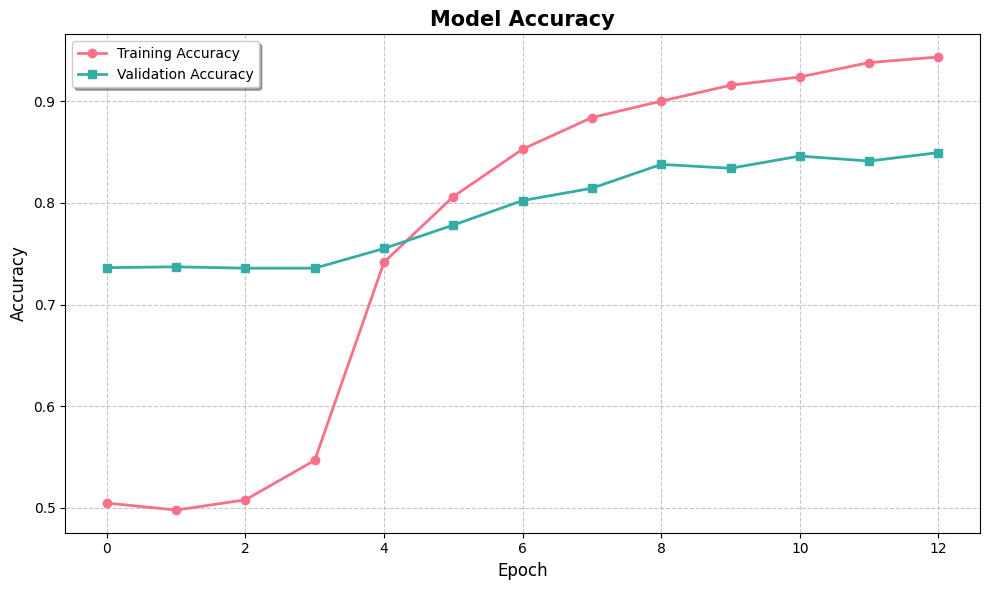

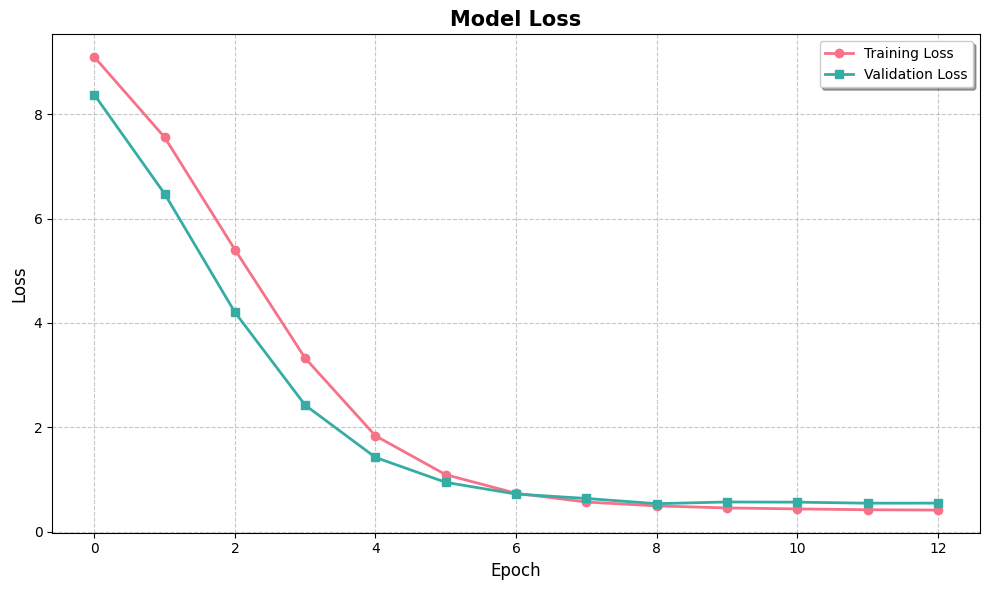

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

colors = sns.color_palette("husl", 2)

# Accuracy plot
plt.figure(figsize=(10, 6))
plt.plot(
    history.history["accuracy"],
    label="Training Accuracy",
    color=colors[0],
    marker="o",
    linestyle="-",
    linewidth=2,
)
plt.plot(
    history.history["val_accuracy"],
    label="Validation Accuracy",
    color=colors[1],
    marker="s",
    linestyle="-",
    linewidth=2,
)
plt.title("Model Accuracy", fontsize=15, fontweight="bold")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(fontsize=10, frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Loss plot
plt.figure(figsize=(10, 6))
plt.plot(
    history.history["loss"],
    label="Training Loss",
    color=colors[0],
    marker="o",
    linestyle="-",
    linewidth=2,
)
plt.plot(
    history.history["val_loss"],
    label="Validation Loss",
    color=colors[1],
    marker="s",
    linestyle="-",
    linewidth=2,
)
plt.title("Model Loss", fontsize=15, fontweight="bold")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=10, frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

712/712 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Overall Results - Confusion Matrices:


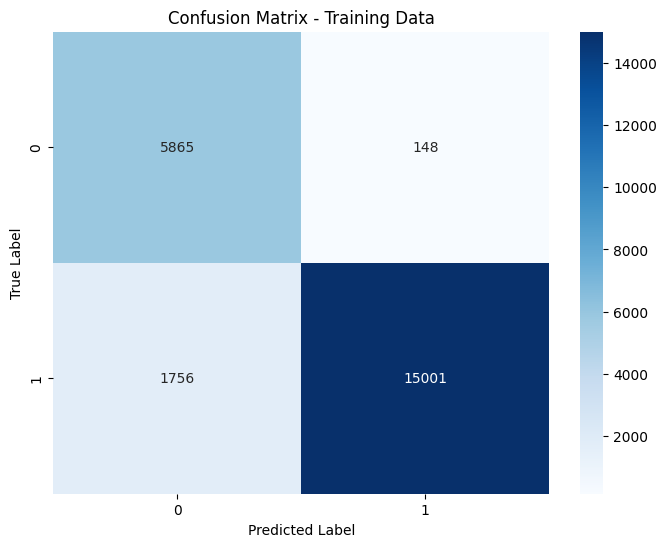

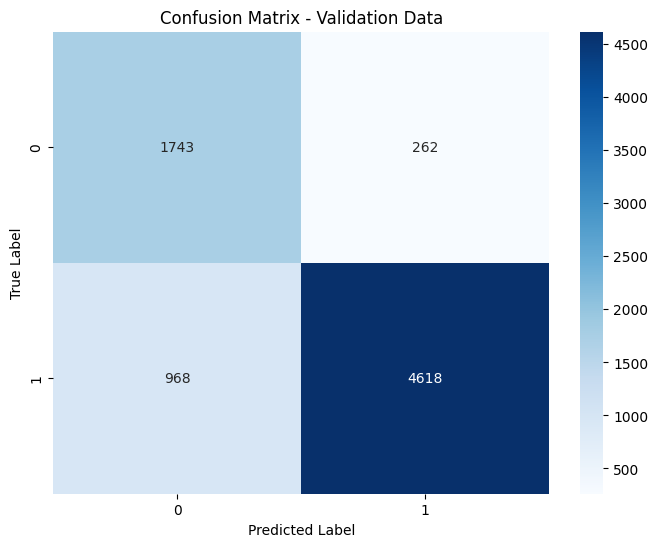

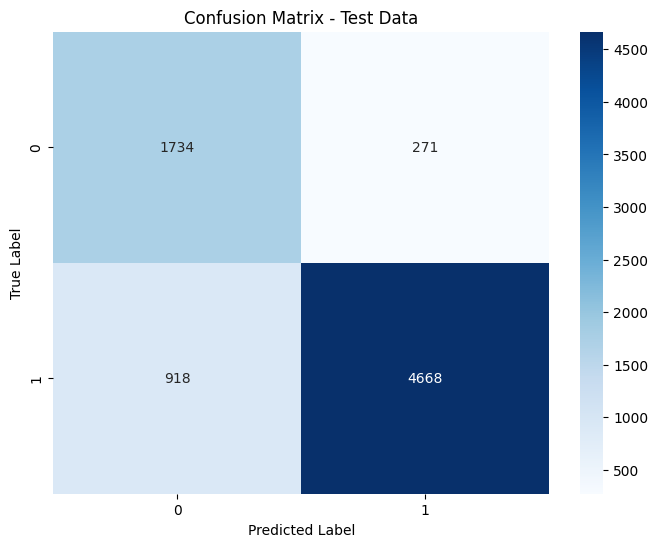

In [6]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {title}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


train_pred = (model.predict(X_train_vec) > 0.5).astype(int)
val_pred = (model.predict(X_val_vec) > 0.5).astype(int)
test_pred = (model.predict(X_test_vec) > 0.5).astype(int)

print("\nOverall Results - Confusion Matrices:")
plot_confusion_matrix(y_train_np, train_pred, "Training Data")
plot_confusion_matrix(y_val_np, val_pred, "Validation Data")
plot_confusion_matrix(y_test_np, test_pred, "Test Data")

In [7]:
def display_classification_report(y_true, y_pred, title):
    print(f"\nClassification Report - {title}")
    print(classification_report(y_true, y_pred))


print("\nOverall Results - Classification Reports:")
display_classification_report(y_train_np, train_pred, "Training Data")
display_classification_report(y_val_np, val_pred, "Validation Data")
display_classification_report(y_test_np, test_pred, "Test Data")


Overall Results - Classification Reports:

Classification Report - Training Data
              precision    recall  f1-score   support

           0       0.77      0.98      0.86      6013
           1       0.99      0.90      0.94     16757

    accuracy                           0.92     22770
   macro avg       0.88      0.94      0.90     22770
weighted avg       0.93      0.92      0.92     22770


Classification Report - Validation Data
              precision    recall  f1-score   support

           0       0.64      0.87      0.74      2005
           1       0.95      0.83      0.88      5586

    accuracy                           0.84      7591
   macro avg       0.79      0.85      0.81      7591
weighted avg       0.87      0.84      0.84      7591


Classification Report - Test Data
              precision    recall  f1-score   support

           0       0.65      0.86      0.74      2005
           1       0.95      0.84      0.89      5586

    accuracy            


Language-specific Confusion Matrices:

EN Results:


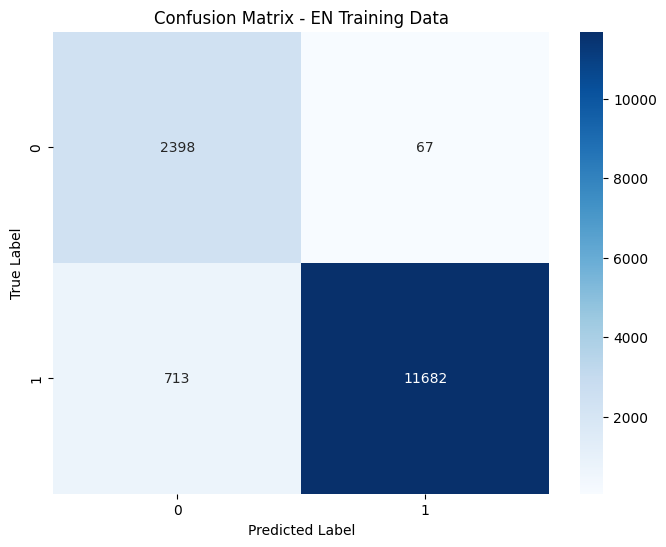

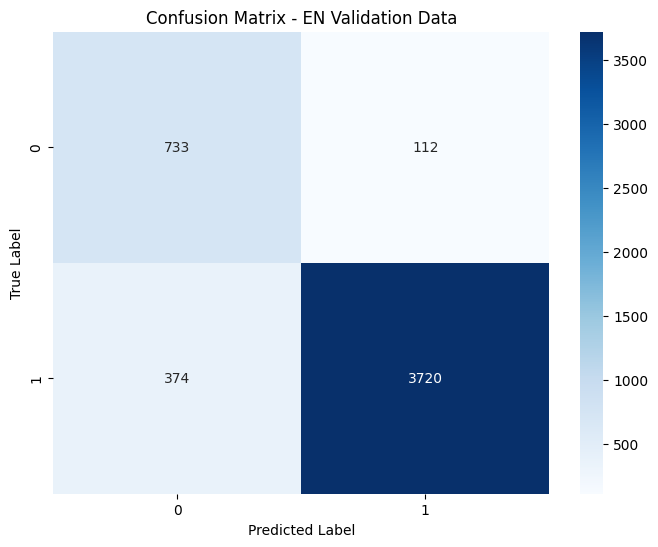

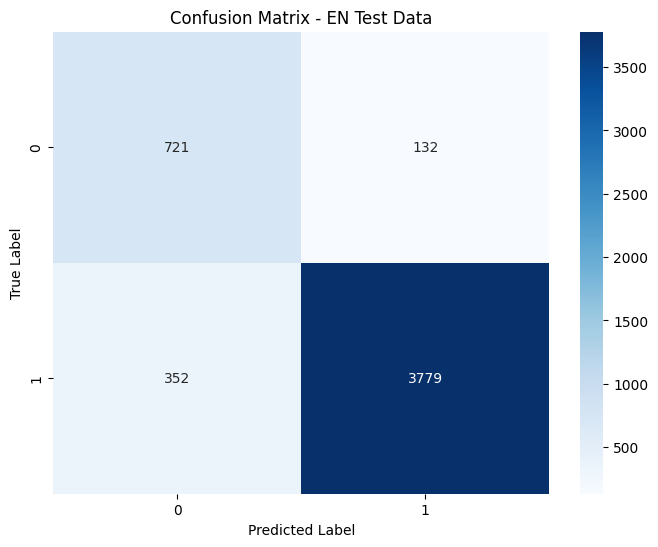


ID Results:


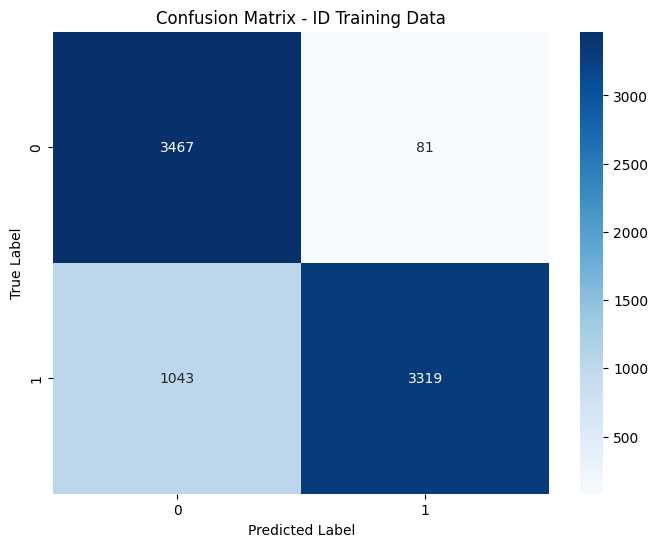

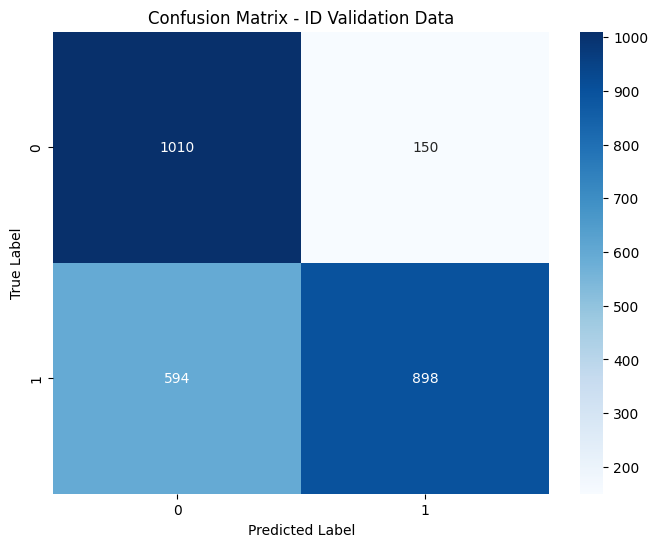

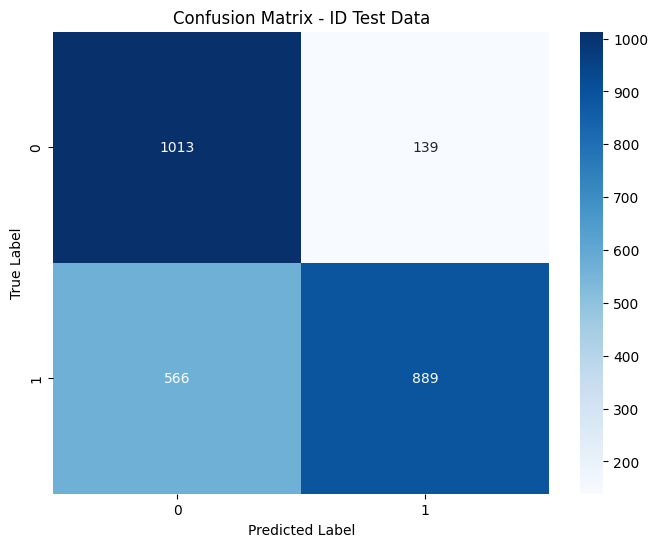

In [8]:
print("\nLanguage-specific Confusion Matrices:")
for lang in ["en", "id"]:
    print(f"\n{lang.upper()} Results:")

    # Get masked indices
    train_mask = langs_train == lang
    val_mask = langs_val == lang
    test_mask = langs_test == lang

    # Get predictions and true values for this language
    train_pred_lang = train_pred[train_mask]
    val_pred_lang = val_pred[val_mask]
    test_pred_lang = test_pred[test_mask]

    train_true_lang = y_train_np[train_mask]
    val_true_lang = y_val_np[val_mask]
    test_true_lang = y_test_np[test_mask]

    # Plot confusion matrices
    plot_confusion_matrix(
        train_true_lang, train_pred_lang, f"{lang.upper()} Training Data"
    )
    plot_confusion_matrix(
        val_true_lang, val_pred_lang, f"{lang.upper()} Validation Data"
    )
    plot_confusion_matrix(test_true_lang, test_pred_lang, f"{lang.upper()} Test Data")

In [9]:
print("\nLanguage-specific Classification Reports:")
for lang in ["en", "id"]:
    print(f"\n{lang.upper()} Results:")

    train_mask = langs_train == lang
    val_mask = langs_val == lang
    test_mask = langs_test == lang

    train_pred_lang = train_pred[train_mask]
    val_pred_lang = val_pred[val_mask]
    test_pred_lang = test_pred[test_mask]

    train_true_lang = y_train_np[train_mask]
    val_true_lang = y_val_np[val_mask]
    test_true_lang = y_test_np[test_mask]

    display_classification_report(
        train_true_lang, train_pred_lang, f"{lang.upper()} Training Data"
    )
    display_classification_report(
        val_true_lang, val_pred_lang, f"{lang.upper()} Validation Data"
    )
    display_classification_report(
        test_true_lang, test_pred_lang, f"{lang.upper()} Test Data"
    )


Language-specific Classification Reports:

EN Results:

Classification Report - EN Training Data
              precision    recall  f1-score   support

           0       0.77      0.97      0.86      2465
           1       0.99      0.94      0.97     12395

    accuracy                           0.95     14860
   macro avg       0.88      0.96      0.91     14860
weighted avg       0.96      0.95      0.95     14860


Classification Report - EN Validation Data
              precision    recall  f1-score   support

           0       0.66      0.87      0.75       845
           1       0.97      0.91      0.94      4094

    accuracy                           0.90      4939
   macro avg       0.82      0.89      0.84      4939
weighted avg       0.92      0.90      0.91      4939


Classification Report - EN Test Data
              precision    recall  f1-score   support

           0       0.67      0.85      0.75       853
           1       0.97      0.91      0.94      4131

  

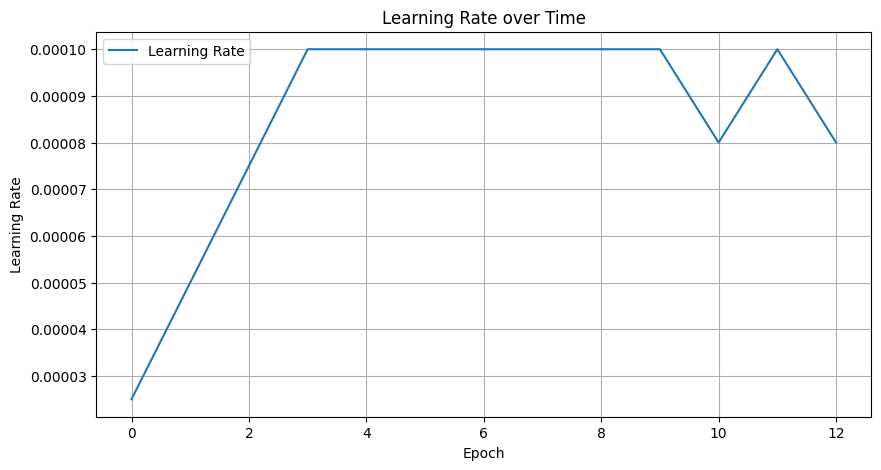

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(history.history["learning_rate"], label="Learning Rate")
plt.title("Learning Rate over Time")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.legend()
plt.grid(True)
plt.show()

712/712 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


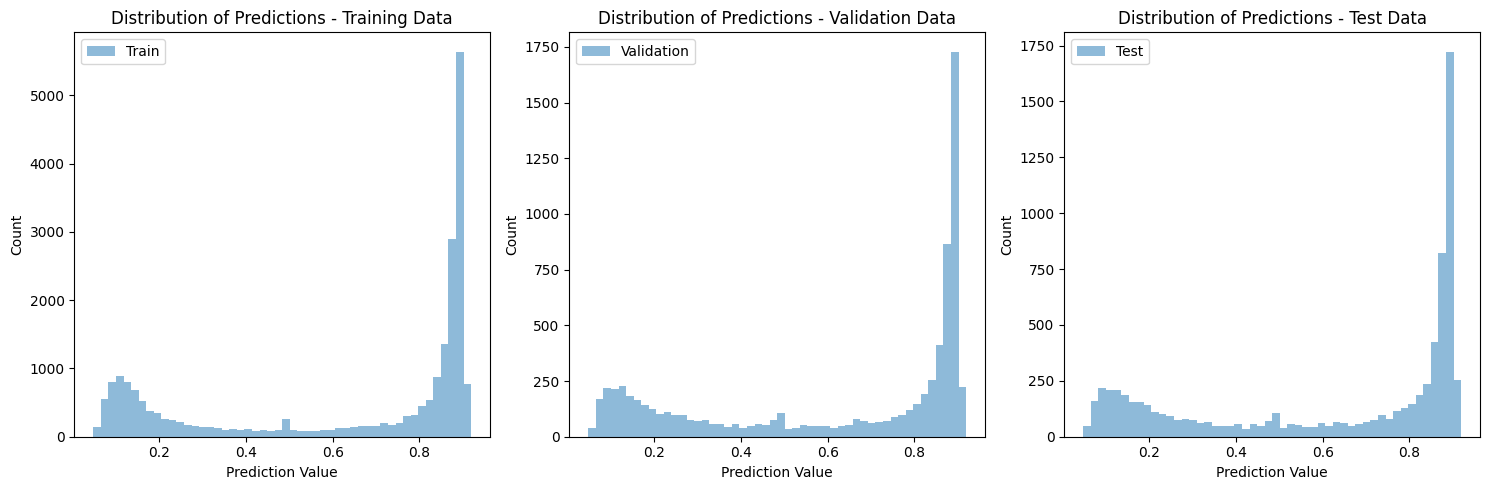

In [11]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.hist(model.predict(X_train_vec), bins=50, alpha=0.5, label="Train")
plt.title("Distribution of Predictions - Training Data")
plt.xlabel("Prediction Value")
plt.ylabel("Count")
plt.legend()

plt.subplot(132)
plt.hist(model.predict(X_val_vec), bins=50, alpha=0.5, label="Validation")
plt.title("Distribution of Predictions - Validation Data")
plt.xlabel("Prediction Value")
plt.ylabel("Count")
plt.legend()

plt.subplot(133)
plt.hist(model.predict(X_test_vec), bins=50, alpha=0.5, label="Test")
plt.title("Distribution of Predictions - Test Data")
plt.xlabel("Prediction Value")
plt.ylabel("Count")
plt.legend()

plt.tight_layout()
plt.show()


ROC Curves:
712/712 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


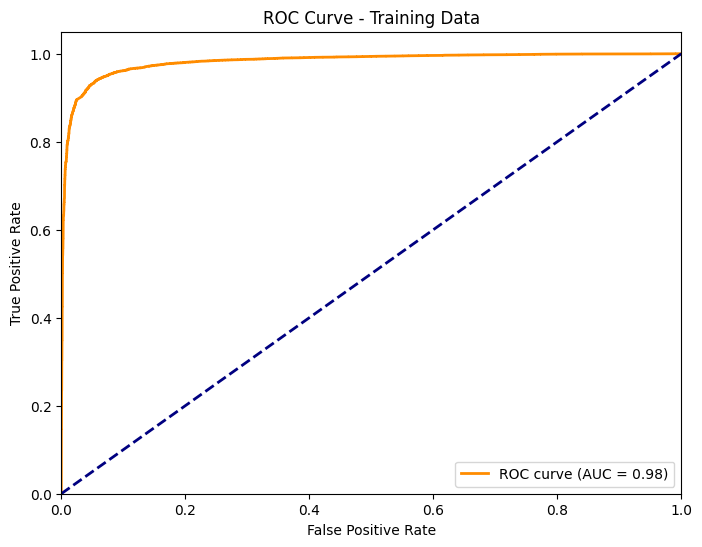

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


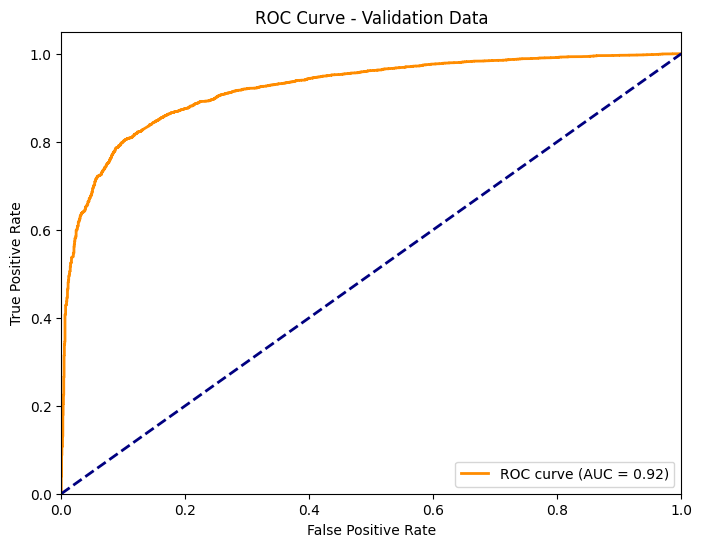

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


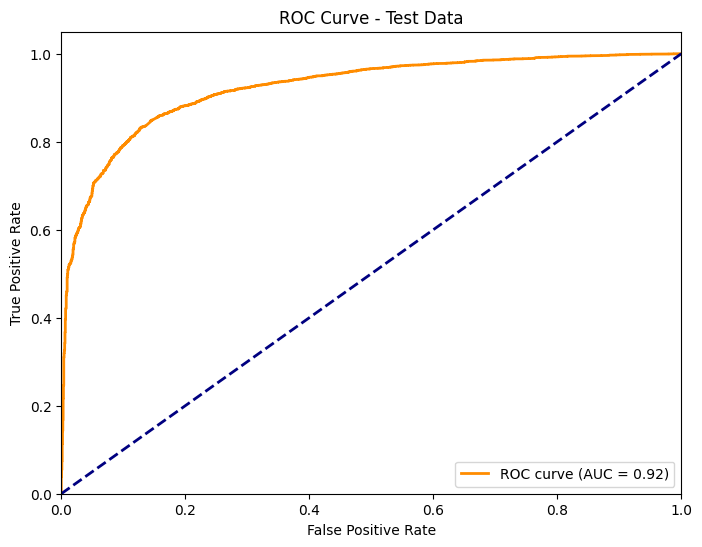

In [12]:
from sklearn.metrics import roc_curve, auc


def plot_roc_curves(y_true, y_pred_proba, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(
        fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})"
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {title}")
    plt.legend(loc="lower right")
    plt.show()


# Plot ROC curves for all datasets
print("\nROC Curves:")
plot_roc_curves(y_train_np, model.predict(X_train_vec), "Training Data")
plot_roc_curves(y_val_np, model.predict(X_val_vec), "Validation Data")
plot_roc_curves(y_test_np, model.predict(X_test_vec), "Test Data")

In [13]:
print("\nModel Summary:")
model.summary()


Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ positional_embedding            │ (None, 200, 64)        │     6,412,864 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 200, 64)        │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 200, 64)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 200, 64)        │        33,472 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 200, 64)        │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 200, 64)        │        33,472 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,459,781 (74.23 MB)

 Trainable params: 6,486,529 (24.74 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 12,973,060 (49.49 MB)

In [14]:
model.save("abussive_detection.keras")
print("\nModel saved as 'abussive_detection.keras'")


Model saved as 'abussive_detection.keras'


In [15]:
import pickle

# Save the TextVectorization configuration
vectorizer_config = {
    "max_tokens": max_tokens,
    "sequence_length": sequence_length,
    "vocabulary": vectorize_layer.get_vocabulary(),
}

with open("vectorizer_config.pkl", "wb") as f:
    pickle.dump(vectorizer_config, f)